## Add some feature to the data: daily high, low and avg. for weather variables and total fires per bin.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.decomposition import PCA

import helper_functions.config as config
import helper_functions.plotting_functions as plotting_functions
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

%matplotlib inline

In [ ]:
# Window size in hrs for min/max/mean
window_size = 24

In [ ]:
# Read data
data = pd.read_parquet(config.raw_data_file)
data.columns = data.columns.str.replace(".", "_")
data.info()

### 1. Cloud coverage

In [ ]:
# first feature to add is average cloud cover from lcdc, mcdc and hcdc - guessing I will be unable
# to get forcasted data which is that specific.
data['cloud_cover'] = data[['lcdc', 'mcdc','hcdc']].mean(axis=1)
data.drop(['lcdc', 'mcdc','hcdc'], inplace=True, axis=1)
data.info()

In [ ]:
data.describe()

### 2. Mean, min and max for continuous weather variables

In [ ]:
# Features to include in min/max/mean. Note: crain ,acpc and veg are excluded - c rain is binary, acpc 
# is a 24 hr cumulative sum and veg is not expected to change much on the timescale of days and weeks
input_features = [
    'date_time',
    'lat',
    'lon',
    'air_2m',
    'rhum_2m',
    'dpt_2m',
    'pres_sfc',
    'uwnd_10m',
    'vwnd_10m',
    'vis',
    'cloud_cover'
]

In [ ]:
# Add mean features

# Names for new columns
new_features = {
    'mean_date_time': 'datetime64[ns]',
    'mean_lat': 'float32',
    'mean_lon': 'float32',
    'mean_air_2m': 'float32',
    'mean_rhum_2m': 'float32',
    'mean_dpt_2m': 'float32',
    'mean_pres_sfc': 'float32',
    'mean_uwnd_10m': 'float32', 
    'mean_vwnd_10m': 'float32',
    'mean_vis': 'float32',
    'mean_cloud_cover': 'float32'
}

# Group by location and calculate mean in rolling window over time
daily_mean = data[input_features].groupby(['lat', 'lon']).rolling(int((window_size/3)), on="date_time").mean()

# Clean up index
daily_mean = daily_mean.droplevel(['lat', 'lon'])
#daily_mean.reset_index(drop=True, inplace=True)

# Rename columns
daily_mean.columns = new_features.keys()

# Set dtypes
daily_mean = daily_mean.astype(new_features)

# Clean up columns
daily_mean.drop(['mean_date_time', 'mean_lat', 'mean_lon'], axis=1, inplace=True)

daily_mean.info()

In [ ]:
# Add max features

# Names for new columns
new_features = {
    'max_date_time': 'datetime64[ns]',
    'max_lat': 'float32',
    'max_lon': 'float32',
    'max_air_2m': 'float32',
    'max_rhum_2m': 'float32',
    'max_dpt_2m': 'float32',
    'max_pres_sfc': 'float32',
    'max_uwnd_10m': 'float32', 
    'max_vwnd_10m': 'float32',
    'max_vis': 'float32',
    'max_cloud_cover': 'float32'
}

# Group by location and calculate mean in rolling window over time
daily_max = data[input_features].groupby(['lat', 'lon']).rolling(int((window_size/3)), on="date_time").max()

# Clean up index
daily_max = daily_max.droplevel(['lat', 'lon'])
#daily_max.reset_index(drop=True, inplace=True)

# Rename columns
daily_max.columns = new_features.keys()

# Set dtypes
daily_max = daily_max.astype(new_features)

# Clean up columns
daily_max.drop(['max_date_time', 'max_lat', 'max_lon'], axis=1, inplace=True)

daily_max.info()

In [ ]:
# Add min. features

# Names for new columns
new_features = {
    'min_date_time': 'datetime64[ns]',
    'min_lat': 'float32',
    'min_lon': 'float32',
    'min_air_2m': 'float32',
    'min_rhum_2m': 'float32',
    'min_dpt_2m': 'float32',
    'min_pres_sfc': 'float32',
    'min_uwnd_10m': 'float32', 
    'min_vwnd_10m': 'float32',
    'min_vis': 'float32',
    'min_cloud_cover': 'float32'
}

# Group by location and calculate mean in rolling window over time
daily_min = data[input_features].groupby(['lat', 'lon']).rolling(int((window_size/3)), on="date_time").min()

# Clean up index
daily_min = daily_min.droplevel(['lat', 'lon'])
#daily_min.reset_index(drop=True, inplace=True)

# Rename columns
daily_min.columns = new_features.keys()

# Set dtypes
daily_min = daily_min.astype(new_features)

# Clean up columns
daily_min.drop(['min_date_time', 'min_lat', 'min_lon'], axis=1, inplace=True)

daily_min.info()

In [ ]:
joined = data.join([daily_mean, daily_max, daily_min])
joined.dropna(inplace=True)
joined.head()

In [ ]:
joined.describe()

In [ ]:
joined.info()

In [ ]:
# Choose one bin at random and retrive one month worth of data
mask = (joined['date_time'] > '1997-07-01') & (joined['date_time'] <= '1997-07-31')

one_fire = joined[
    (joined['lat'] == 39.30418) &
    (joined['lon'] == -123.2773)
]

one_fire = one_fire.loc[mask]

# Sort data for plotting
one_fire = one_fire.sort_values(by='date_time',ascending=True)

# Add hour number
one_fire.insert(0, 'hour', range(1, (3 * len(one_fire)), 3))

In [ ]:
one_fire.head()

In [ ]:
# Plot weather features for single fire
# xmin = min(one_fire['hour'])
# xmax = max(one_fire['hour'])
xmin = 200
xmax = 450

plt.subplots(2,2,figsize=(14,4))

plt.subplot(1, 4, 1)

plt.plot(
    one_fire['hour'], 
    one_fire['air_2m'],
    color = "darkgray",
    label ='Raw'
)
plt.plot(
    one_fire['hour'], 
    one_fire['min_air_2m'],
    color = "royalblue",
    label ='Min.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['max_air_2m'],
    color = "royalblue",
    label ='Max.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['mean_air_2m'],
    color = "darkorange",
    label ='Mean'
)
plt.xlabel('Hour')
plt.ylabel('Temperature (K)')
plt.title('Air temperature')
plt.legend()
plt.xlim(xmin,xmax)


plt.subplot(1, 4, 2)

plt.plot(
    one_fire['hour'], 
    one_fire['rhum_2m'],
    color = "darkgray",
    label ='Raw'
)
plt.plot(
    one_fire['hour'], 
    one_fire['min_rhum_2m'],
    color = "royalblue",
    label ='Min.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['max_rhum_2m'],
    color = "royalblue",
    label ='Max.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['mean_rhum_2m'],
    color = "darkorange",
    label ='Mean'
)
plt.xlabel('Hour')
plt.ylabel('Humidity (%)')
plt.title('Relative humidity')
plt.legend()
plt.xlim(xmin,xmax)


plt.subplot(1, 4, 3)

plt.plot(
    one_fire['hour'], 
    one_fire['pres_sfc'],
    color = "darkgray",
    label ='Raw'
)
plt.plot(
    one_fire['hour'], 
    one_fire['min_pres_sfc'],
    color = "royalblue",
    label ='Min.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['max_pres_sfc'],
    color = "royalblue",
    label ='Max.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['mean_pres_sfc'],
    color = "darkorange",
    label ='Mean'
)
plt.xlabel('Hour')
plt.ylabel('Pressure (Pa)')
plt.title('Surface pressure')
plt.legend()
plt.xlim(xmin,xmax)


plt.subplot(1, 4, 4)

plt.scatter(
    one_fire['hour'], 
    one_fire['ignition'],
    color = "darkred"
)

plt.xlabel('Hour')
plt.ylabel('Ignition')
plt.title('Ignition')
plt.xlim(xmin,xmax)


plt.tight_layout()
plt.savefig('../project_info/figures/CA_only_min_max_mean_added.png', bbox_inches='tight')
plt.show()

**One step further - take daily average to reduce size of dataset**

In [ ]:
joined['year'] = pd.DatetimeIndex(joined['date_time']).year.astype('int32')
joined['month'] = pd.DatetimeIndex(joined['date_time']).month.astype('int32')
joined['day'] = pd.DatetimeIndex(joined['date_time']).day.astype('int32')

In [ ]:
joined.info()

In [ ]:
joined = joined.groupby([
    'lat', 
    'lon', 
    'year',
    'month',
    'day'
]).mean().reset_index()

joined.loc[joined['ignition'] > 0, 'ignition'] = 1.0
joined.reset_index(drop=True, inplace=True)
joined.info()

In [ ]:
#date = pd.to_datetime(joined['year'], joined['month'], joined['day'])
joined['date'] = pd.to_datetime(dict(year=joined.year, month=joined.month, day=joined.day))
joined = joined.astype({'lat': 'float32', 'lon': 'float32'})

In [ ]:
to_drop = [
    'year',
    'day',
    'air_2m',
    'rhum_2m',
    'dpt_2m',
    'pres_sfc',
    'uwnd_10m',
    'vwnd_10m',
    'vis',
    'cloud_cover'
]
joined.drop(to_drop, axis=1, inplace=True)

In [ ]:
joined.info()

In [ ]:
joined.head()

In [ ]:
# Choose one bin at random and retrive one month worth of data
mask = (joined['date'] > '1997-07-01') & (joined['date'] <= '1997-07-31')

one_fire = joined[
    (joined['lat'] == 39.30418) &
    (joined['lon'] == -123.2773)
]

one_fire = one_fire.loc[mask]

# Sort data for plotting
one_fire = one_fire.sort_values(by='date',ascending=True)

# Add hour number
one_fire.insert(0, 'hour', range(1, (24 * len(one_fire)), 24))

In [ ]:
one_fire.head()

In [ ]:
# Plot weather features for single fire
# xmin = min(one_fire['hour'])
# xmax = max(one_fire['hour'])
xmin = 200
xmax = 450

plt.subplots(2,2,figsize=(14,4))

plt.subplot(1, 4, 1)

plt.plot(
    one_fire['hour'], 
    one_fire['min_air_2m'],
    color = "royalblue",
    label ='Min.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['max_air_2m'],
    color = "royalblue",
    label ='Max.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['mean_air_2m'],
    color = "darkorange",
    label ='Mean'
)
plt.xlabel('Hour')
plt.ylabel('Temperature (K)')
plt.title('Air temperature')
plt.legend()
#plt.xlim(xmin,xmax)


plt.subplot(1, 4, 2)

plt.plot(
    one_fire['hour'], 
    one_fire['min_rhum_2m'],
    color = "royalblue",
    label ='Min.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['max_rhum_2m'],
    color = "royalblue",
    label ='Max.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['mean_rhum_2m'],
    color = "darkorange",
    label ='Mean'
)
plt.xlabel('Hour')
plt.ylabel('Humidity (%)')
plt.title('Relative humidity')
plt.legend()
#plt.xlim(xmin,xmax)


plt.subplot(1, 4, 3)

plt.plot(
    one_fire['hour'], 
    one_fire['min_pres_sfc'],
    color = "royalblue",
    label ='Min.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['max_pres_sfc'],
    color = "royalblue",
    label ='Max.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['mean_pres_sfc'],
    color = "darkorange",
    label ='Mean'
)
plt.xlabel('Hour')
plt.ylabel('Pressure (Pa)')
plt.title('Surface pressure')
plt.legend()
#plt.xlim(xmin,xmax)


plt.subplot(1, 4, 4)

plt.scatter(
    one_fire['hour'], 
    one_fire['ignition'],
    color = "darkred",
    label = "Spread"
)

plt.xlabel('Hour')
plt.ylabel('Ignition')
plt.title('Ignition')
plt.xlim(xmin,xmax)


plt.tight_layout()
plt.savefig('../project_info/figures/CA_only_daily_mean_min_max_mean_added.png', bbox_inches='tight')
plt.show()

In [ ]:
raw_percent_ignition = np.round(((len(data[data['ignition'] == 1])/len(data))*100),2)
joined_percent_ignition = np.round(((len(joined[joined['ignition'] == 1])/len(joined))*100),2)
print("Raw data is {}% ignition".format(raw_percent_ignition))
print("Processed data is {}% ignition".format(joined_percent_ignition))








**Add total fires per lat/lon bin**

In [ ]:
total_fires = data[['lat', 'lon', 'ignition']].groupby(['lat', 'lon']).sum()
joined['total_fires'] = joined.apply(lambda x: total_fires.loc[(x['lat'], x['lon'])], axis=1)

In [ ]:
joined.info()

In [ ]:
dtypes = {
    'lat':                 'float32',
    'lon':                 'float32',
    'month':               'int32',
    'crain':               'int32',
    'veg':                 'float32',
    'ignition':            'int32',
    'mean_air_2m':         'float32',
    'mean_rhum_2m':        'float32',
    'mean_dpt_2m':         'float32',
    'mean_pres_sfc':       'float32',
    'mean_uwnd_10m':       'float32',
    'mean_vwnd_10m':       'float32',
    'mean_vis':            'float32',
    'mean_cloud_cover':    'float32',
    'max_air_2m':          'float32',
    'max_rhum_2m':         'float32',
    'max_dpt_2m':          'float32',
    'max_pres_sfc':        'float32',
    'max_uwnd_10m':        'float32',
    'max_vwnd_10m':        'float32',
    'max_vis':             'float32',
    'max_cloud_cover':     'float32',
    'min_air_2m':          'float32',
    'min_rhum_2m':         'float32',
    'min_dpt_2m':          'float32',
    'min_pres_sfc':        'float32',
    'min_uwnd_10m':        'float32',
    'min_vwnd_10m':        'float32',
    'min_vis':             'float32',
    'min_cloud_cover':     'float32',
    'total_fires':         'int32',
    'date':                'datetime64[ns]'
}

joined = joined.astype(dtypes)

In [ ]:
joined.head()

In [ ]:
joined.info()

In [ ]:
joined.to_parquet('/mnt/SSD/data/training_data/1992-2015_california_min-max_added.parquet')

In [2]:
joined = pd.read_parquet('/mnt/SSD/data/training_data/1992-2015_california_min-max_added.parquet')

raw_lat = joined['lat']
raw_lon = joined['lon']
dates = joined['date']

In [3]:
joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 33 columns):
 #   Column            Dtype         
---  ------            -----         
 0   lat               float32       
 1   lon               float32       
 2   month             int32         
 3   apcp              float32       
 4   crain             int32         
 5   veg               float32       
 6   ignition          int32         
 7   mean_air_2m       float32       
 8   mean_rhum_2m      float32       
 9   mean_dpt_2m       float32       
 10  mean_pres_sfc     float32       
 11  mean_uwnd_10m     float32       
 12  mean_vwnd_10m     float32       
 13  mean_vis          float32       
 14  mean_cloud_cover  float32       
 15  max_air_2m        float32       
 16  max_rhum_2m       float32       
 17  max_dpt_2m        float32       
 18  max_pres_sfc      float32       
 19  max_uwnd_10m      float32       
 20  max_vwnd_10m      float32       
 21  max_vis 

## 1) Mean only: raw

In [4]:
feature_names = [
    'lat',
    'lon',
    'month',
    'apcp',
    'crain',
    'veg',
    'mean_air_2m',    
    'mean_rhum_2m', 
    'mean_dpt_2m', 
    'mean_pres_sfc', 
    'mean_uwnd_10m', 
    'mean_vwnd_10m', 
    'mean_vis', 
    'mean_cloud_cover',
    'total_fires',
    'ignition'
]

raw_data = joined[feature_names]
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 16 columns):
 #   Column            Dtype  
---  ------            -----  
 0   lat               float32
 1   lon               float32
 2   month             int32  
 3   apcp              float32
 4   crain             int32  
 5   veg               float32
 6   mean_air_2m       float32
 7   mean_rhum_2m      float32
 8   mean_dpt_2m       float32
 9   mean_pres_sfc     float32
 10  mean_uwnd_10m     float32
 11  mean_vwnd_10m     float32
 12  mean_vis          float32
 13  mean_cloud_cover  float32
 14  total_fires       int32  
 15  ignition          int32  
dtypes: float32(12), int32(4)
memory usage: 219.4 MB


In [5]:
raw_data['raw_lat'] = raw_lat
raw_data['raw_lon'] = raw_lon
raw_data['date'] = dates

raw_data.to_parquet('/mnt/SSD/data/training_data/1992-2015_california_raw_mean.parquet')

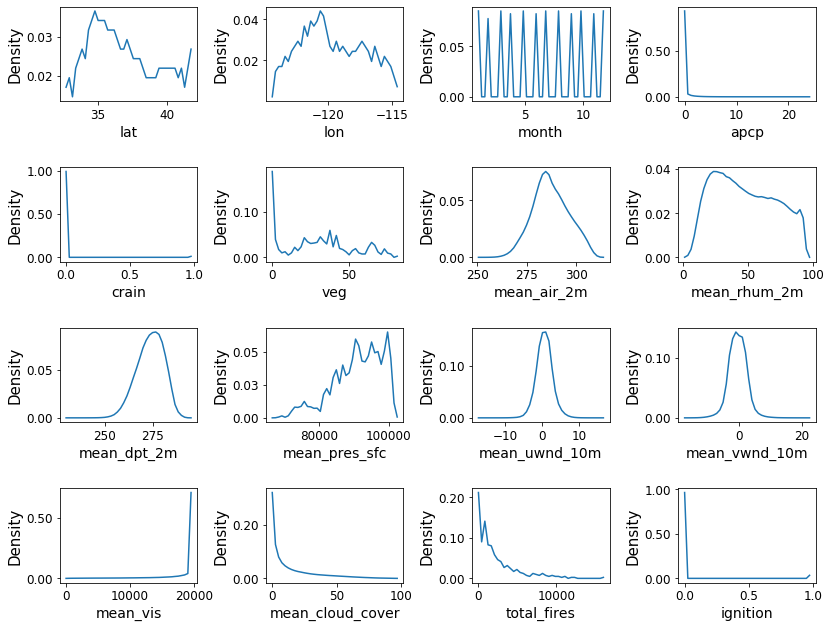

In [6]:
# plot weather data distributions
left = config.left
right = config.right
bottom = config.bottom
top = config.top
wspace = config.wspace
hspace = config.hspace
fig_rows = 4
fig_cols = 4
plot_height = 10
plot_width = config.plot_width

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3),
    (2,0),(2,1),(2,2),(2,3),
    (3,0),(3,1),(3,2),(3,3)
]

xlabels = feature_names
ylabels = ['Density'] * len(feature_names)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(feature_names)):
    ax[plot_locations[i]] = plotting_functions.one_sample_density_plot(
        ax,
        plot_locations[i], 
        raw_data, 
        feature_names[i], 
        feature_names[i], 
        feature_names[i], 
        ylabels[i]
    )

## 2) Mean only: (0, 1) scaled

In [7]:
# min-max scale data into (0, 1)

features_to_scale = [
    'lat',       
    'lon',       
    'month',         
    'apcp',    
    #'crain',     
    'veg',     
    #'ignition',       
    'mean_air_2m',      
    'mean_rhum_2m',    
    'mean_dpt_2m',     
    'mean_pres_sfc',     
    'mean_uwnd_10m',  
    'mean_vwnd_10m',   
    'mean_vis',      
    'mean_cloud_cover',         
    'total_fires'
]

data_types = {      
    'lat': 'float32',       
    'lon': 'float32',  
    'month': 'float32',         
    'apcp': 'float32',    
    'crain': 'int32',     
    'veg': 'float32',     
    'ignition': 'int32',       
    'mean_air_2m': 'float32',      
    'mean_rhum_2m': 'float32',    
    'mean_dpt_2m': 'float32',     
    'mean_pres_sfc': 'float32',     
    'mean_uwnd_10m': 'float32',  
    'mean_vwnd_10m': 'float32',   
    'mean_vis': 'float32',      
    'mean_cloud_cover': 'float32',       
    'total_fires': 'float32',      
}

scaled_data = raw_data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data[features_to_scale] = scaler.fit_transform(raw_data[features_to_scale])

scaled_data = scaled_data.astype(data_types)

scaled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 19 columns):
 #   Column            Dtype         
---  ------            -----         
 0   lat               float32       
 1   lon               float32       
 2   month             float32       
 3   apcp              float32       
 4   crain             int32         
 5   veg               float32       
 6   mean_air_2m       float32       
 7   mean_rhum_2m      float32       
 8   mean_dpt_2m       float32       
 9   mean_pres_sfc     float32       
 10  mean_uwnd_10m     float32       
 11  mean_vwnd_10m     float32       
 12  mean_vis          float32       
 13  mean_cloud_cover  float32       
 14  total_fires       float32       
 15  ignition          int32         
 16  raw_lat           float32       
 17  raw_lon           float32       
 18  date              datetime64[ns]
dtypes: datetime64[ns](1), float32(16), int32(2)
memory usage: 274.2 MB


In [8]:
scaled_data['raw_lat'] = raw_lat
scaled_data['raw_lon'] = raw_lon
scaled_data['date'] = dates

scaled_data.to_parquet('/mnt/SSD/data/training_data/1992-2015_california_min0_max1_scaled_mean.parquet')

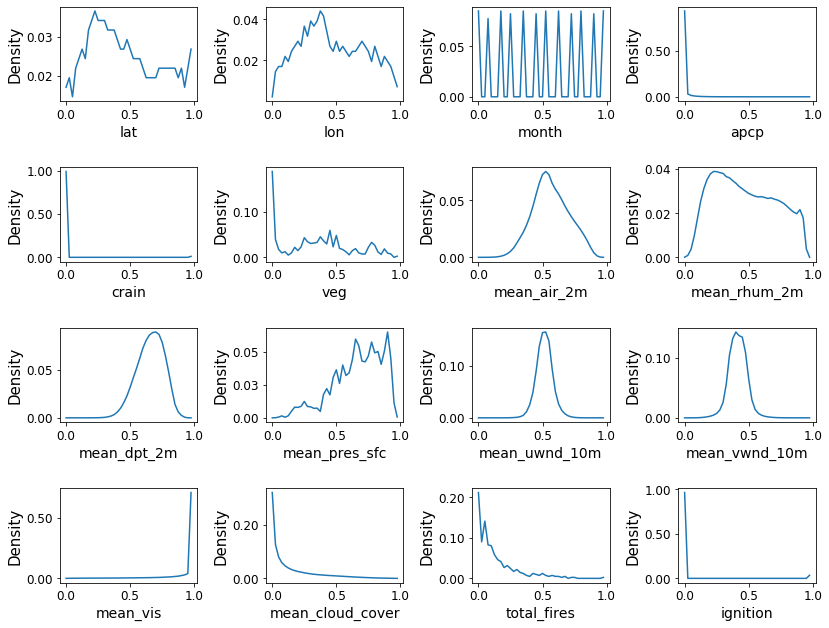

In [9]:
# plot weather data distributions
left = config.left
right = config.right
bottom = config.bottom
top = config.top
wspace = config.wspace
hspace = config.hspace
fig_rows = 4
fig_cols = 4
plot_height = 10
plot_width = config.plot_width

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3),
    (2,0),(2,1),(2,2),(2,3),
    (3,0),(3,1),(3,2),(3,3)
]

xlabels = feature_names
ylabels = ['Density'] * len(feature_names)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(feature_names)):
    ax[plot_locations[i]] = plotting_functions.one_sample_density_plot(
        ax,
        plot_locations[i], 
        scaled_data, 
        feature_names[i], 
        feature_names[i], 
        feature_names[i], 
        ylabels[i]
    )

## 3) Mean only: (-1, 1) scaled

In [10]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data[features_to_scale] = scaler.fit_transform(raw_data[features_to_scale])

scaled_data = scaled_data.astype(data_types)

scaled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 19 columns):
 #   Column            Dtype         
---  ------            -----         
 0   lat               float32       
 1   lon               float32       
 2   month             float32       
 3   apcp              float32       
 4   crain             int32         
 5   veg               float32       
 6   mean_air_2m       float32       
 7   mean_rhum_2m      float32       
 8   mean_dpt_2m       float32       
 9   mean_pres_sfc     float32       
 10  mean_uwnd_10m     float32       
 11  mean_vwnd_10m     float32       
 12  mean_vis          float32       
 13  mean_cloud_cover  float32       
 14  total_fires       float32       
 15  ignition          int32         
 16  raw_lat           float32       
 17  raw_lon           float32       
 18  date              datetime64[ns]
dtypes: datetime64[ns](1), float32(16), int32(2)
memory usage: 274.2 MB


In [11]:
scaled_data['raw_lat'] = raw_lat
scaled_data['raw_lon'] = raw_lon
scaled_data['date'] = dates

scaled_data.to_parquet('/mnt/SSD/data/training_data/1992-2015_california_min-1_max1_scaled_mean.parquet')

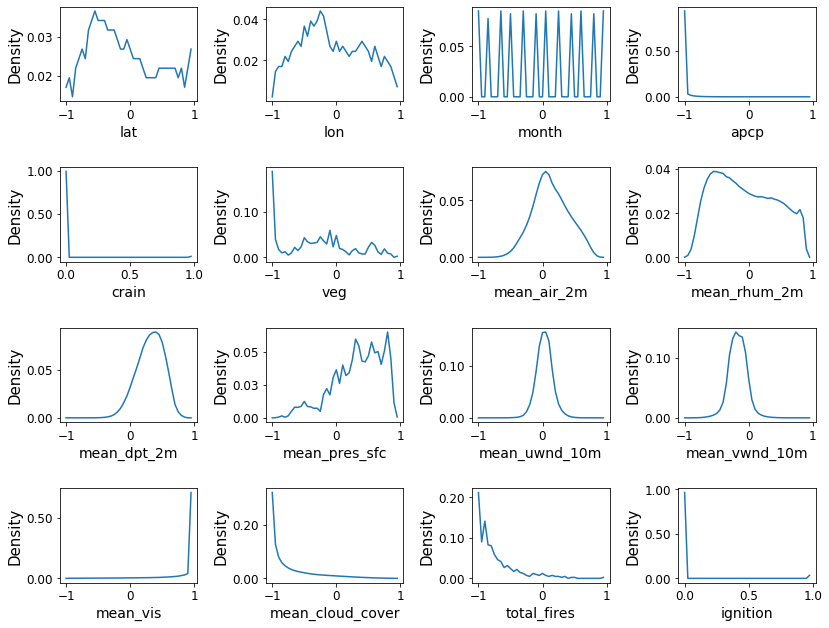

In [12]:
# plot weather data distributions
left = config.left
right = config.right
bottom = config.bottom
top = config.top
wspace = config.wspace
hspace = config.hspace
fig_rows = 4
fig_cols = 4
plot_height = 10
plot_width = config.plot_width

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3),
    (2,0),(2,1),(2,2),(2,3),
    (3,0),(3,1),(3,2),(3,3)
]

xlabels = feature_names
ylabels = ['Density'] * len(feature_names)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(feature_names)):
    ax[plot_locations[i]] = plotting_functions.one_sample_density_plot(
        ax,
        plot_locations[i], 
        scaled_data, 
        feature_names[i], 
        feature_names[i], 
        feature_names[i], 
        ylabels[i]
    )

## 4) Mean only: z-score scaled

In [13]:
joined = pd.read_parquet('/mnt/SSD/data/training_data/1992-2015_california_min-max_added.parquet')

feature_names = [
    'lat',
    'lon',
    'month',
    'apcp',
    'crain',
    'veg',
    'mean_air_2m',    
    'mean_rhum_2m', 
    'mean_dpt_2m', 
    'mean_pres_sfc', 
    'mean_uwnd_10m', 
    'mean_vwnd_10m', 
    'mean_vis', 
    'mean_cloud_cover',
    'total_fires',
    'ignition'
]

raw_data = joined[feature_names]

scaler = StandardScaler()
scaled_data[features_to_scale] = scaler.fit_transform(raw_data[features_to_scale])

scaled_data = scaled_data.astype(data_types)

scaled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 19 columns):
 #   Column            Dtype         
---  ------            -----         
 0   lat               float32       
 1   lon               float32       
 2   month             float32       
 3   apcp              float32       
 4   crain             int32         
 5   veg               float32       
 6   mean_air_2m       float32       
 7   mean_rhum_2m      float32       
 8   mean_dpt_2m       float32       
 9   mean_pres_sfc     float32       
 10  mean_uwnd_10m     float32       
 11  mean_vwnd_10m     float32       
 12  mean_vis          float32       
 13  mean_cloud_cover  float32       
 14  total_fires       float32       
 15  ignition          int32         
 16  raw_lat           float32       
 17  raw_lon           float32       
 18  date              datetime64[ns]
dtypes: datetime64[ns](1), float32(16), int32(2)
memory usage: 274.2 MB


In [14]:
scaled_data['raw_lat'] = raw_lat
scaled_data['raw_lon'] = raw_lon
scaled_data['date'] = dates

scaled_data.to_parquet('/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean.parquet')

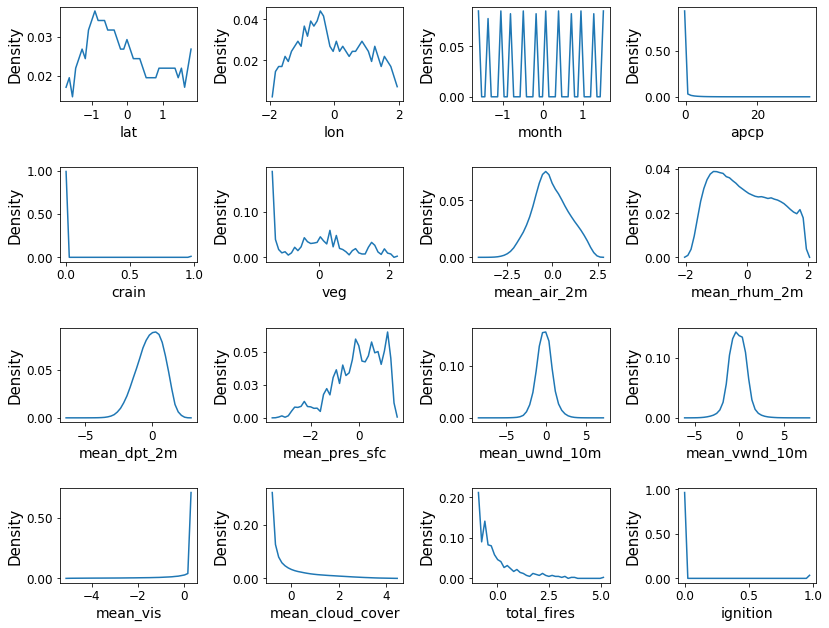

In [15]:
# plot weather data distributions
left = config.left
right = config.right
bottom = config.bottom
top = config.top
wspace = config.wspace
hspace = config.hspace
fig_rows = 4
fig_cols = 4
plot_height = 10
plot_width = config.plot_width

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3),
    (2,0),(2,1),(2,2),(2,3),
    (3,0),(3,1),(3,2),(3,3)
]

xlabels = feature_names
ylabels = ['Density'] * len(feature_names)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(feature_names)):
    ax[plot_locations[i]] = plotting_functions.one_sample_density_plot(
        ax,
        plot_locations[i], 
        scaled_data, 
        feature_names[i], 
        feature_names[i], 
        feature_names[i], 
        ylabels[i]
    )

## 6) Mean only: z-score scaled, selective Box-Cox

In [16]:
raw_data = joined[feature_names]

features_to_scale = [
    'lat',
    'lon',
    'month',
    'apcp',
#    'crain',
    'veg',
    'mean_air_2m',    
    'mean_rhum_2m', 
    'mean_dpt_2m', 
    'mean_pres_sfc', 
    'mean_uwnd_10m', 
    'mean_vwnd_10m', 
    'mean_vis', 
    'mean_cloud_cover',
    'total_fires',
#    'ignition'
]

features_to_transform = [
#     'lat',
#     'lon',
#     'month',
    'apcp',
#    'crain',
    'veg',
#     'mean_air_2m',    
#     'mean_rhum_2m', 
#     'mean_dpt_2m', 
    'mean_pres_sfc', 
#     'mean_uwnd_10m', 
#     'mean_vwnd_10m', 
    'mean_vis', 
    'mean_cloud_cover',
    'total_fires',
#    'ignition'
]

scaled_data = raw_data

qt = QuantileTransformer(random_state = 0, output_distribution = 'normal')
transformed_data = pd.DataFrame(qt.fit_transform(scaled_data[features_to_transform]), columns=features_to_transform)
scaled_data[features_to_transform] = transformed_data

scaler = StandardScaler()
scaled_data[features_to_scale] = scaler.fit_transform(scaled_data[features_to_scale])

scaled_data = scaled_data.astype(data_types)

scaled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 16 columns):
 #   Column            Dtype  
---  ------            -----  
 0   lat               float32
 1   lon               float32
 2   month             float32
 3   apcp              float32
 4   crain             int32  
 5   veg               float32
 6   mean_air_2m       float32
 7   mean_rhum_2m      float32
 8   mean_dpt_2m       float32
 9   mean_pres_sfc     float32
 10  mean_uwnd_10m     float32
 11  mean_vwnd_10m     float32
 12  mean_vis          float32
 13  mean_cloud_cover  float32
 14  total_fires       float32
 15  ignition          int32  
dtypes: float32(14), int32(2)
memory usage: 219.4 MB


In [17]:
scaled_data['raw_lat'] = raw_lat
scaled_data['raw_lon'] = raw_lon
scaled_data['date'] = dates

scaled_data.to_parquet('/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_selective_box_cox.parquet')

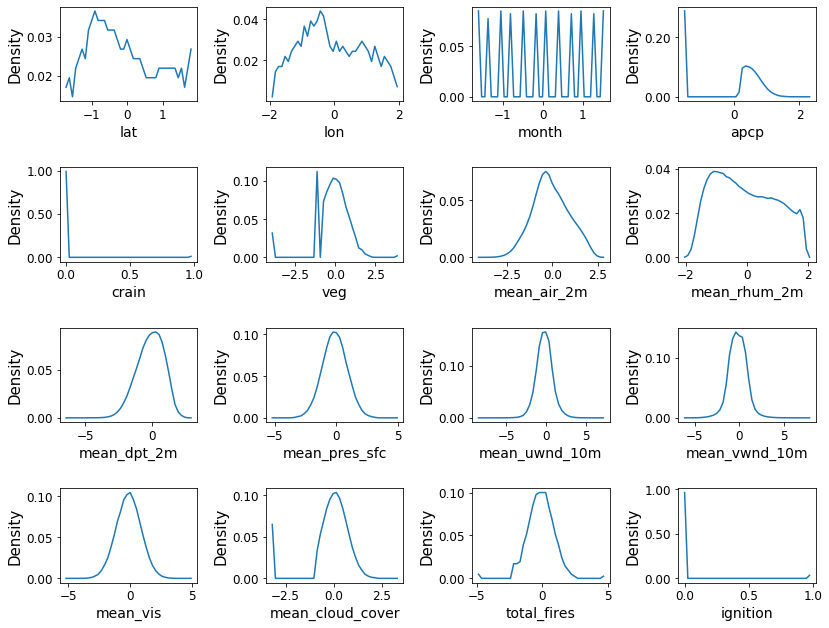

In [18]:
# plot weather data distributions
left = config.left
right = config.right
bottom = config.bottom
top = config.top
wspace = config.wspace
hspace = config.hspace
fig_rows = 4
fig_cols = 4
plot_height = 10
plot_width = config.plot_width

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3),
    (2,0),(2,1),(2,2),(2,3),
    (3,0),(3,1),(3,2),(3,3)
]

xlabels = feature_names
ylabels = ['Density'] * len(feature_names)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(feature_names)):
    ax[plot_locations[i]] = plotting_functions.one_sample_density_plot(
        ax,
        plot_locations[i], 
        scaled_data, 
        feature_names[i], 
        feature_names[i], 
        feature_names[i], 
        ylabels[i]
    )

## 7) Mean only: z-score scaled, full Box-Cox

In [19]:
features_to_scale = [
    'lat',
    'lon',
    'month',
    'apcp',
#    'crain',
    'veg',
    'mean_air_2m',    
    'mean_rhum_2m', 
    'mean_dpt_2m', 
    'mean_pres_sfc', 
    'mean_uwnd_10m', 
    'mean_vwnd_10m', 
    'mean_vis', 
    'mean_cloud_cover',
    'total_fires',
#    'ignition'
]

features_to_transform = [
    'lat',
    'lon',
#    'month',
    'apcp',
#    'crain',
    'veg',
    'mean_air_2m',    
    'mean_rhum_2m', 
    'mean_dpt_2m', 
    'mean_pres_sfc', 
    'mean_uwnd_10m', 
    'mean_vwnd_10m', 
    'mean_vis', 
    'mean_cloud_cover',
    'total_fires',
#    'ignition'
]

scaled_data = raw_data

qt = QuantileTransformer(random_state = 0, output_distribution = 'normal')
transformed_data = pd.DataFrame(qt.fit_transform(scaled_data[features_to_transform]), columns=features_to_transform)
scaled_data[features_to_transform] = transformed_data

scaler = StandardScaler()
scaled_data[features_to_scale] = scaler.fit_transform(scaled_data[features_to_scale])

scaled_data = scaled_data.astype(data_types)

scaled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 16 columns):
 #   Column            Dtype  
---  ------            -----  
 0   lat               float32
 1   lon               float32
 2   month             float32
 3   apcp              float32
 4   crain             int32  
 5   veg               float32
 6   mean_air_2m       float32
 7   mean_rhum_2m      float32
 8   mean_dpt_2m       float32
 9   mean_pres_sfc     float32
 10  mean_uwnd_10m     float32
 11  mean_vwnd_10m     float32
 12  mean_vis          float32
 13  mean_cloud_cover  float32
 14  total_fires       float32
 15  ignition          int32  
dtypes: float32(14), int32(2)
memory usage: 219.4 MB


In [20]:
scaled_data['raw_lat'] = raw_lat
scaled_data['raw_lon'] = raw_lon
scaled_data['date'] = dates

scaled_data.to_parquet('/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_full_box_cox.parquet')

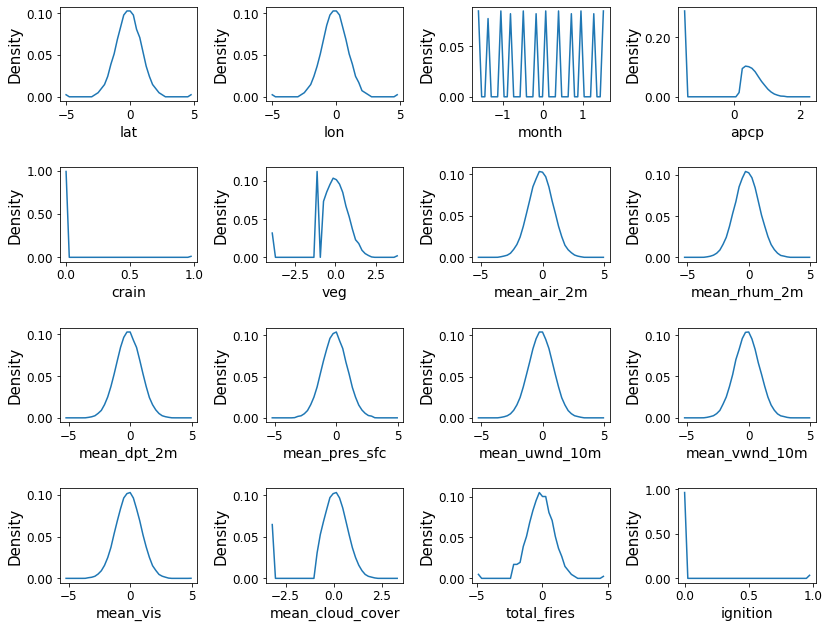

In [21]:
# plot weather data distributions
left = config.left
right = config.right
bottom = config.bottom
top = config.top
wspace = config.wspace
hspace = config.hspace
fig_rows = 4
fig_cols = 4
plot_height = 10
plot_width = config.plot_width

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3),
    (2,0),(2,1),(2,2),(2,3),
    (3,0),(3,1),(3,2),(3,3)
]

xlabels = feature_names
ylabels = ['Density'] * len(feature_names)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(feature_names)):
    ax[plot_locations[i]] = plotting_functions.one_sample_density_plot(
        ax,
        plot_locations[i], 
        scaled_data, 
        feature_names[i], 
        feature_names[i], 
        feature_names[i], 
        ylabels[i]
    )

## 8) Absolute min, max

In [22]:
data = pd.read_parquet('/mnt/SSD/data/training_data/1992-2015_california_min-max_added.parquet')

dates = data['date']
raw_lat = data['lat']
raw_lon = data['lon']

data.drop('date', inplace=True, axis=1)

In [23]:
features_to_scale = [
    'lat',
    'lon',
    'month',
    'apcp',
#    'crain',
    'veg',
    'mean_air_2m',    
    'mean_rhum_2m', 
    'mean_dpt_2m', 
    'mean_pres_sfc', 
    'mean_uwnd_10m', 
    'mean_vwnd_10m', 
    'mean_vis', 
    'mean_cloud_cover',
    'min_air_2m',    
    'min_rhum_2m', 
    'min_dpt_2m', 
    'min_pres_sfc', 
    'min_uwnd_10m', 
    'min_vwnd_10m', 
    'min_vis', 
    'min_cloud_cover',
    'max_air_2m',    
    'max_rhum_2m', 
    'max_dpt_2m', 
    'max_pres_sfc', 
    'max_uwnd_10m', 
    'max_vwnd_10m', 
    'max_vis', 
    'max_cloud_cover',
    'total_fires',
#    'ignition'
]

features_to_transform = [
#     'lat',
#     'lon',
#     'month',
    'apcp',
#    'crain',
    'veg',
#     'mean_air_2m',    
#     'mean_rhum_2m', 
#     'mean_dpt_2m', 
    'mean_pres_sfc', 
#     'mean_uwnd_10m', 
#     'mean_vwnd_10m', 
    'mean_vis', 
    'mean_cloud_cover',
    'total_fires',
#    'ignition'
#     'min_air_2m',    
    'min_rhum_2m', 
#     'min_dpt_2m', 
    'min_pres_sfc', 
#     'min_uwnd_10m', 
#     'min_vwnd_10m', 
    'min_vis', 
    'min_cloud_cover',
#     'max_air_2m',    
    'max_rhum_2m', 
#     'max_dpt_2m', 
    'max_pres_sfc', 
#     'max_uwnd_10m', 
#     'max_vwnd_10m', 
    'max_vis', 
    'max_cloud_cover'
]

data_types = {      
    'lat': 'float32',       
    'lon': 'float32',  
    'month': 'float32',         
    'apcp': 'float32',    
    'crain': 'int32',     
    'veg': 'float32',     
    'ignition': 'int32',       
    'mean_air_2m': 'float32',      
    'mean_rhum_2m': 'float32',    
    'mean_dpt_2m': 'float32',     
    'mean_pres_sfc': 'float32',     
    'mean_uwnd_10m': 'float32',  
    'mean_vwnd_10m': 'float32',   
    'mean_vis': 'float32',      
    'mean_cloud_cover': 'float32',
    'min_air_2m': 'float32',
    'min_rhum_2m': 'float32',
    'min_dpt_2m': 'float32',
    'min_pres_sfc': 'float32',
    'min_uwnd_10m': 'float32',
    'min_vwnd_10m': 'float32',
    'min_vis': 'float32',
    'min_cloud_cover': 'float32',
    'max_air_2m': 'float32',
    'max_rhum_2m': 'float32',
    'max_dpt_2m': 'float32',
    'max_pres_sfc': 'float32',
    'max_uwnd_10m': 'float32',
    'max_vwnd_10m': 'float32',
    'max_vis': 'float32',
    'max_cloud_cover': 'float32',
    'total_fires': 'float32'  
}

scaled_data = data

qt = QuantileTransformer(random_state = 0, output_distribution = 'normal')
transformed_data = pd.DataFrame(qt.fit_transform(scaled_data[features_to_transform]), columns=features_to_transform)
scaled_data[features_to_transform] = transformed_data

scaler = StandardScaler()
scaled_data[features_to_scale] = scaler.fit_transform(scaled_data[features_to_scale])

scaled_data = scaled_data.astype(data_types)

In [24]:
scaled_data['raw_lat'] = raw_lat
scaled_data['raw_lon'] = raw_lon
scaled_data['date'] = dates

scaled_data.to_parquet('/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_abs_min_max_selective_box_cox.parquet')

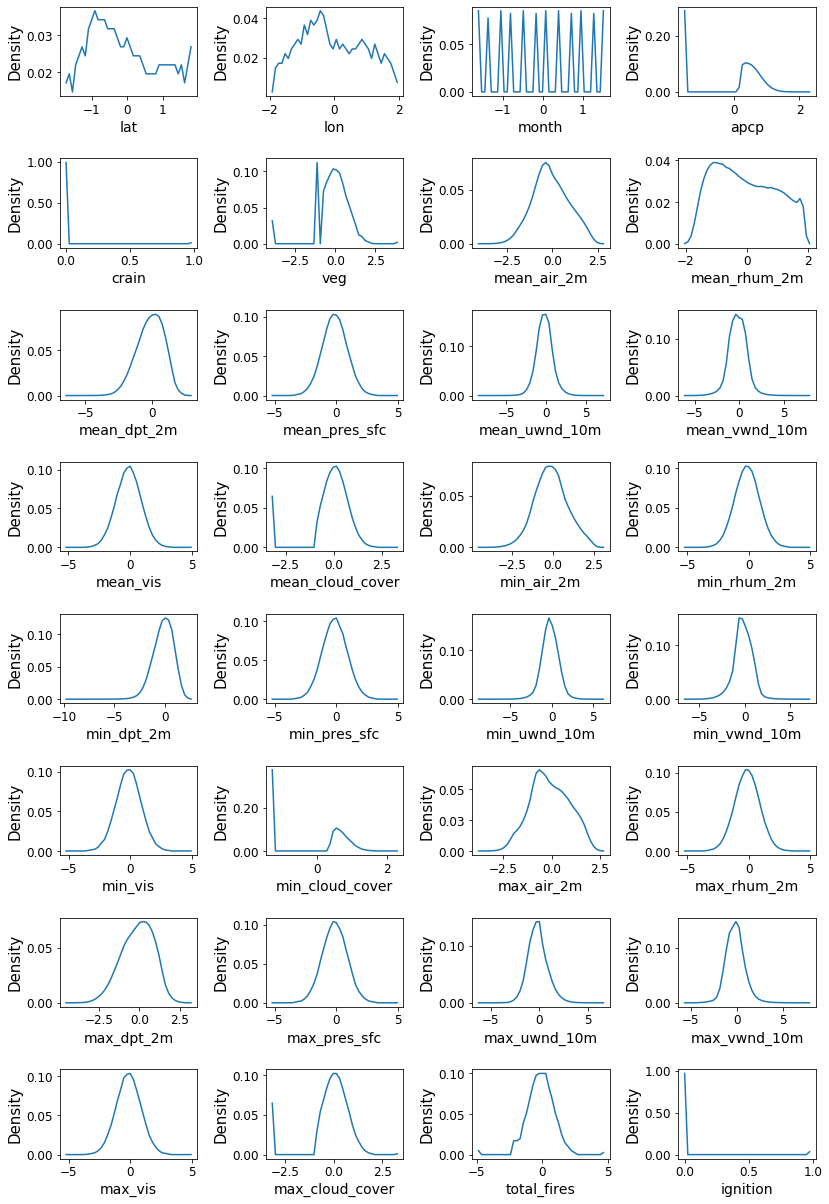

In [25]:
# plot weather data distributions
left = config.left
right = config.right
bottom = config.bottom
top = config.top
wspace = config.wspace
hspace = config.hspace
fig_rows = 8
fig_cols = 4
plot_height = 20
plot_width = config.plot_width

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3),
    (2,0),(2,1),(2,2),(2,3),
    (3,0),(3,1),(3,2),(3,3),
    (4,0),(4,1),(4,2),(4,3),
    (5,0),(5,1),(5,2),(5,3),
    (6,0),(6,1),(6,2),(6,3),
    (7,0),(7,1),(7,2),(7,3)
]


feature_names = [
    'lat',
    'lon',
    'month',
    'apcp',
    'crain',
    'veg',
    'mean_air_2m',    
    'mean_rhum_2m', 
    'mean_dpt_2m', 
    'mean_pres_sfc', 
    'mean_uwnd_10m', 
    'mean_vwnd_10m', 
    'mean_vis', 
    'mean_cloud_cover',
    'min_air_2m',    
    'min_rhum_2m', 
    'min_dpt_2m', 
    'min_pres_sfc', 
    'min_uwnd_10m', 
    'min_vwnd_10m', 
    'min_vis', 
    'min_cloud_cover',
    'max_air_2m',    
    'max_rhum_2m', 
    'max_dpt_2m', 
    'max_pres_sfc', 
    'max_uwnd_10m', 
    'max_vwnd_10m', 
    'max_vis', 
    'max_cloud_cover',
    'total_fires',
    'ignition'
]

xlabels = feature_names
ylabels = ['Density'] * len(feature_names)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(feature_names)):
    ax[plot_locations[i]] = plotting_functions.one_sample_density_plot(
        ax,
        plot_locations[i], 
        scaled_data, 
        feature_names[i], 
        feature_names[i], 
        feature_names[i], 
        ylabels[i]
    )

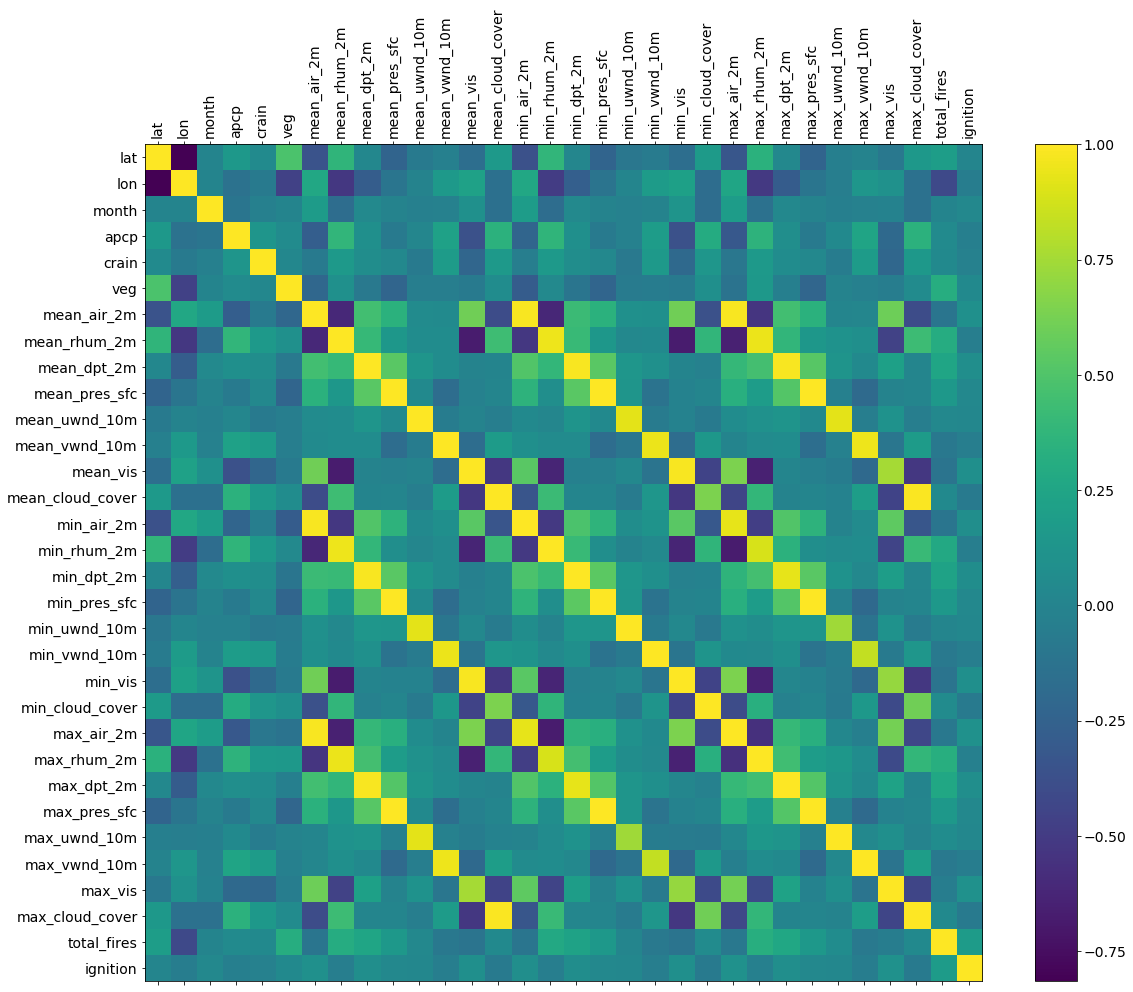

In [26]:
features = scaled_data[feature_names]

f = plt.figure(figsize=(19, 15))
plt.matshow(features.corr(), fignum=f.number)
plt.xticks(range(features.shape[1]), features.columns, fontsize=14, rotation=90)
plt.yticks(range(features.shape[1]), features.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

## 9) Plus-minus min, max

In [27]:
feature_base_names = [
    'air_2m',      
    'rhum_2m', 
    'dpt_2m', 
    'pres_sfc', 
    'uwnd_10m', 
    'vwnd_10m', 
    'vis', 
    'cloud_cover', 
]

In [28]:
for base_name in feature_base_names:
    min_name = f'min_{base_name}'
    max_name = f'max_{base_name}'
    mean_name = f'mean_{base_name}'
    
    scaled_data[min_name] = scaled_data[mean_name] - data[min_name]
    scaled_data[max_name] = scaled_data[max_name] - data[mean_name]
    

features_to_scale = [
#     'lat',
#     'lon',
#     'month',
#     'apcp',
#     'crain',
#     'veg',
#     'mean_air_2m',    
#     'mean_rhum_2m', 
#     'mean_dpt_2m', 
#     'mean_pres_sfc', 
#     'mean_uwnd_10m', 
#     'mean_vwnd_10m', 
#     'mean_vis', 
#     'mean_cloud_cover',
    'min_air_2m',    
    'min_rhum_2m', 
    'min_dpt_2m', 
    'min_pres_sfc', 
    'min_uwnd_10m', 
    'min_vwnd_10m', 
    'min_vis', 
    'min_cloud_cover',
    'max_air_2m',    
    'max_rhum_2m', 
    'max_dpt_2m', 
    'max_pres_sfc', 
    'max_uwnd_10m', 
    'max_vwnd_10m', 
    'max_vis', 
    'max_cloud_cover',
#     'total_fires',
#    'ignition'
]

features_to_transform = [
#     'lat',
#     'lon',
#     'month',
#     'apcp',
#     'crain',
#     'veg',
#     'mean_air_2m',    
#     'mean_rhum_2m', 
#     'mean_dpt_2m', 
#     'mean_pres_sfc', 
#     'mean_uwnd_10m', 
#     'mean_vwnd_10m', 
#     'mean_vis', 
#     'mean_cloud_cover',
#     'total_fires',
#     'ignition'
#     'min_air_2m',    
#     'min_rhum_2m', 
#     'min_dpt_2m', 
#     'min_pres_sfc', 
#     'min_uwnd_10m', 
#     'min_vwnd_10m', 
#     'min_vis', 
#     'min_cloud_cover',
#     'max_air_2m',    
#     'max_rhum_2m', 
#     'max_dpt_2m', 
#     'max_pres_sfc', 
#     'max_uwnd_10m', 
#     'max_vwnd_10m', 
#     'max_vis', 
#     'max_cloud_cover'
]
    

# qt = QuantileTransformer(random_state = 0, output_distribution = 'normal')
# transformed_data = pd.DataFrame(qt.fit_transform(scaled_data[features_to_transform]), columns=features_to_transform)
# scaled_data[features_to_transform] = transformed_data

scaler = StandardScaler()
scaled_data[features_to_scale] = scaler.fit_transform(scaled_data[features_to_scale])

scaled_data = scaled_data.astype(data_types)

In [29]:
scaled_data['raw_lat'] = raw_lat
scaled_data['raw_lon'] = raw_lon
scaled_data['date'] = dates

scaled_data.to_parquet('/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_plus-minus_min_max_selective_box_cox.parquet')

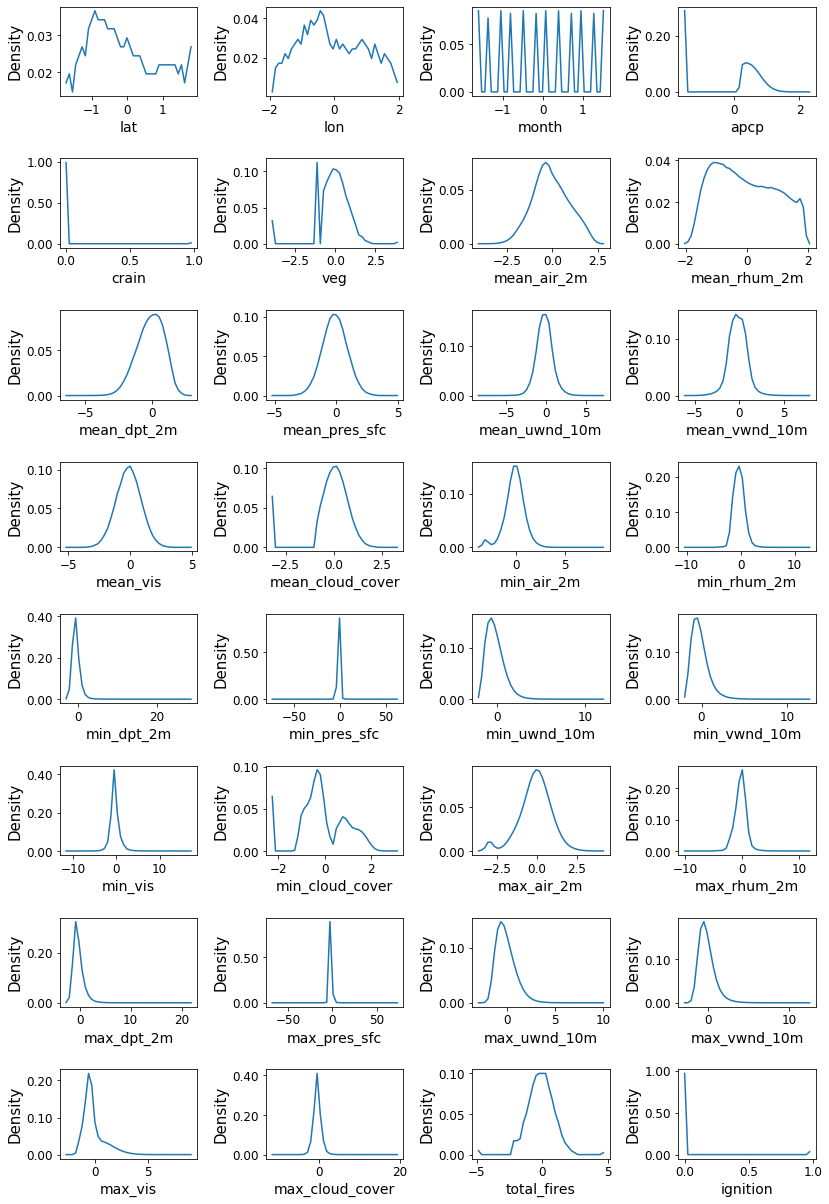

In [30]:
# plot weather data distributions
left = config.left
right = config.right
bottom = config.bottom
top = config.top
wspace = config.wspace
hspace = config.hspace
fig_rows = 8
fig_cols = 4
plot_height = 20
plot_width = config.plot_width

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3),
    (2,0),(2,1),(2,2),(2,3),
    (3,0),(3,1),(3,2),(3,3),
    (4,0),(4,1),(4,2),(4,3),
    (5,0),(5,1),(5,2),(5,3),
    (6,0),(6,1),(6,2),(6,3),
    (7,0),(7,1),(7,2),(7,3)
]

xlabels = feature_names
ylabels = ['Density'] * len(feature_names)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(feature_names)):
    ax[plot_locations[i]] = plotting_functions.one_sample_density_plot(
        ax,
        plot_locations[i], 
        scaled_data, 
        feature_names[i], 
        feature_names[i], 
        feature_names[i], 
        ylabels[i]
    )

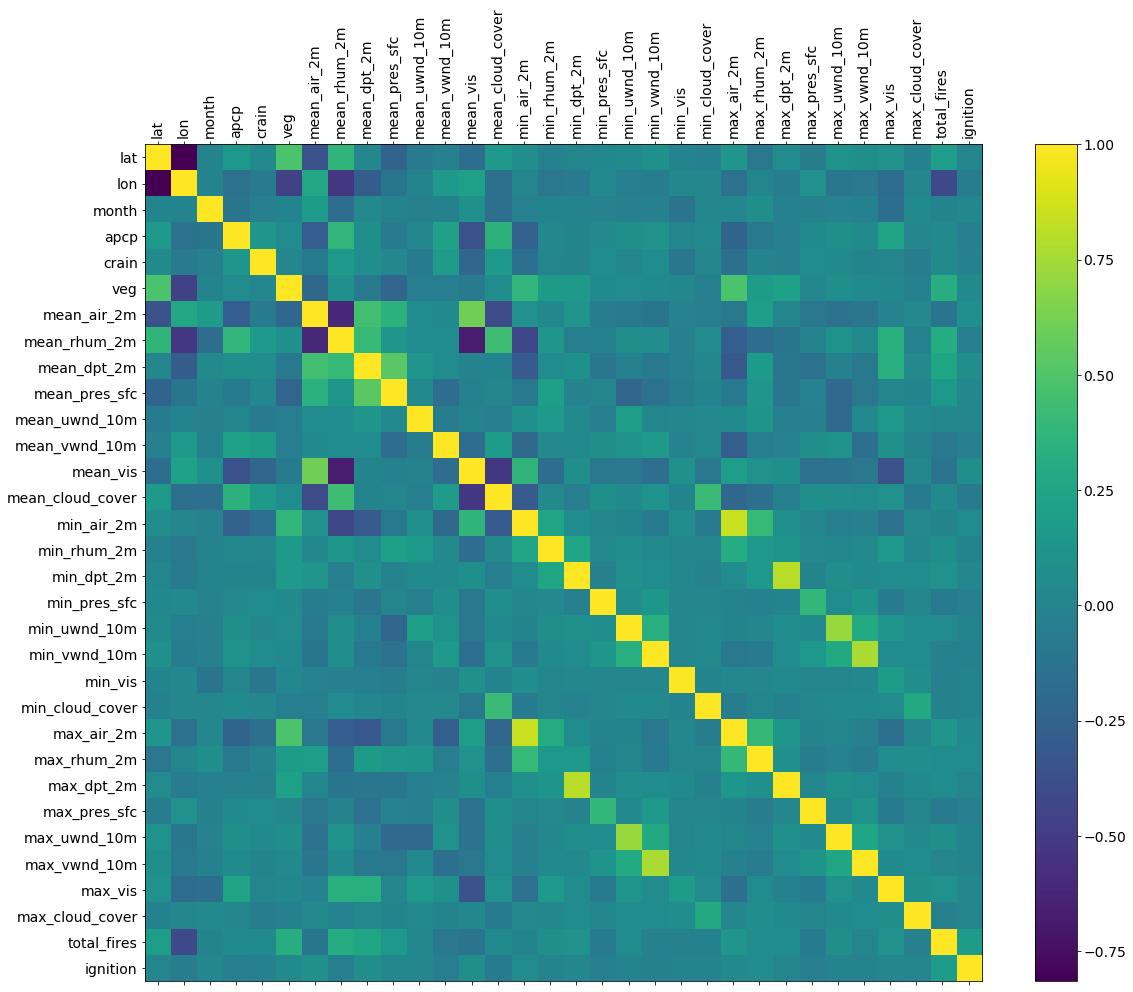

In [31]:
features = scaled_data[feature_names]

f = plt.figure(figsize=(19, 15))
plt.matshow(features.corr(), fignum=f.number)
plt.xticks(range(features.shape[1]), features.columns, fontsize=14, rotation=90)
plt.yticks(range(features.shape[1]), features.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

OK, cool! Now daily variability is included in the dataset, with less strong correlations between the min/max and the mean. The issue now is that the min and max are strongly correlated. Maybe we can simplify the whole thing and remove this correlation by using a 'range' variable instead of separate min and max variables.

## 10) Range

In [32]:
for base_name in feature_base_names:
    min_name = f'min_{base_name}'
    max_name = f'max_{base_name}'
    range_name = f'range_{base_name}'
    
    scaled_data[range_name] = scaled_data[max_name] - scaled_data[min_name]

features_to_scale = [
#     'lat',
#     'lon',
#     'month',
#     'apcp',
#     'crain',
#     'veg',
#     'mean_air_2m',    
#     'mean_rhum_2m', 
#     'mean_dpt_2m', 
#     'mean_pres_sfc', 
#     'mean_uwnd_10m', 
#     'mean_vwnd_10m', 
#     'mean_vis', 
#     'mean_cloud_cover',
    'range_air_2m',    
    'range_rhum_2m', 
    'range_dpt_2m', 
    'range_pres_sfc', 
    'range_uwnd_10m', 
    'range_vwnd_10m', 
    'range_vis', 
    'range_cloud_cover',
    'total_fires',
#    'ignition'
]

features_to_transform = [
#     'lat',
#     'lon',
#     'month',
#     'apcp',
#     'crain',
#     'veg',
#     'mean_air_2m',    
#     'mean_rhum_2m', 
#     'mean_dpt_2m', 
#     'mean_pres_sfc', 
#     'mean_uwnd_10m', 
#     'mean_vwnd_10m', 
#     'mean_vis', 
#     'mean_cloud_cover',
#     'range_air_2m',    
#     'range_rhum_2m', 
#     'range_dpt_2m', 
#     'range_pres_sfc', 
#     'range_uwnd_10m', 
#     'range_vwnd_10m', 
#     'range_vis', 
#     'range_cloud_cover',
#     'total_fires',
#     'ignition'
]

data_types = {      
    'lat': 'float32',       
    'lon': 'float32',  
    'month': 'float32',         
    'apcp': 'float32',    
    'crain': 'int32',     
    'veg': 'float32',     
    'ignition': 'int32',       
    'mean_air_2m': 'float32',      
    'mean_rhum_2m': 'float32',    
    'mean_dpt_2m': 'float32',     
    'mean_pres_sfc': 'float32',     
    'mean_uwnd_10m': 'float32',  
    'mean_vwnd_10m': 'float32',   
    'mean_vis': 'float32',      
    'mean_cloud_cover': 'float32',
    'range_air_2m': 'float32',
    'range_rhum_2m': 'float32',
    'range_dpt_2m': 'float32',
    'range_pres_sfc': 'float32',
    'range_uwnd_10m': 'float32',
    'range_vwnd_10m': 'float32',
    'range_vis': 'float32',
    'range_cloud_cover': 'float32',
    'total_fires': 'float32'  
}   

# qt = QuantileTransformer(random_state = 0, output_distribution = 'normal')
# transformed_data = pd.DataFrame(qt.fit_transform(scaled_data[features_to_transform]), columns=features_to_transform)
# scaled_data[features_to_transform] = transformed_data

scaler = StandardScaler()
scaled_data[features_to_scale] = scaler.fit_transform(scaled_data[features_to_scale])

scaled_data = scaled_data.astype(data_types)

features_to_drop = [
    'max_air_2m',     
    'max_rhum_2m',   
    'max_dpt_2m',   
    'max_pres_sfc',   
    'max_uwnd_10m',   
    'max_vwnd_10m',  
    'max_vis',     
    'max_cloud_cover',   
    'min_air_2m',
    'min_rhum_2m',
    'min_dpt_2m',
    'min_pres_sfc', 
    'min_uwnd_10m',  
    'min_vwnd_10m',
    'min_vis',
    'min_cloud_cover'
]

scaled_data.drop(features_to_drop, axis=1, inplace=True)
scaled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 27 columns):
 #   Column             Dtype         
---  ------             -----         
 0   lat                float32       
 1   lon                float32       
 2   month              float32       
 3   apcp               float32       
 4   crain              int32         
 5   veg                float32       
 6   ignition           int32         
 7   mean_air_2m        float32       
 8   mean_rhum_2m       float32       
 9   mean_dpt_2m        float32       
 10  mean_pres_sfc      float32       
 11  mean_uwnd_10m      float32       
 12  mean_vwnd_10m      float32       
 13  mean_vis           float32       
 14  mean_cloud_cover   float32       
 15  total_fires        float32       
 16  raw_lat            float32       
 17  raw_lon            float32       
 18  date               datetime64[ns]
 19  range_air_2m       float32       
 20  range_rhum_2m      float

In [33]:
scaled_data['raw_lat'] = raw_lat
scaled_data['raw_lon'] = raw_lon
scaled_data['date'] = dates

scaled_data.to_parquet('/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_range_selective_box_cox.parquet')

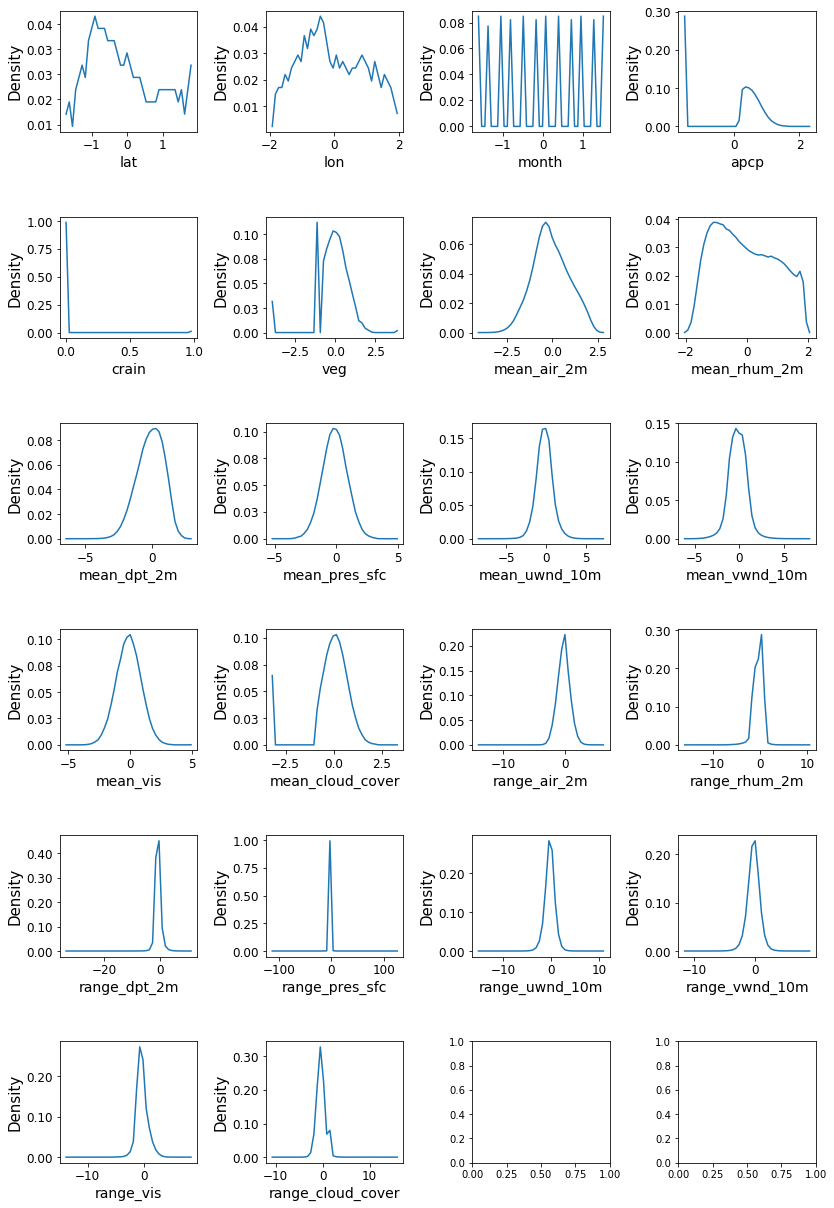

In [34]:
# plot weather data distributions
left = config.left
right = config.right
bottom = config.bottom
top = config.top
wspace = config.wspace
hspace = config.hspace
fig_rows = 6
fig_cols = 4
plot_height = 20
plot_width = config.plot_width

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3),
    (2,0),(2,1),(2,2),(2,3),
    (3,0),(3,1),(3,2),(3,3),
    (4,0),(4,1),(4,2),(4,3),
    (5,0),(5,1),(5,2),(5,3)
]

feature_names = [
    'lat',
    'lon',
    'month',
    'apcp',
    'crain',
    'veg',
    'mean_air_2m',       
    'mean_rhum_2m', 
    'mean_dpt_2m', 
    'mean_pres_sfc', 
    'mean_uwnd_10m', 
    'mean_vwnd_10m', 
    'mean_vis', 
    'mean_cloud_cover',
    'range_air_2m',
    'range_rhum_2m', 
    'range_dpt_2m',
    'range_pres_sfc',
    'range_uwnd_10m',
    'range_vwnd_10m',
    'range_vis',
    'range_cloud_cover',    
]

xlabels = feature_names
ylabels = ['Density'] * len(feature_names)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(feature_names)):
    ax[plot_locations[i]] = plotting_functions.one_sample_density_plot(
        ax,
        plot_locations[i], 
        scaled_data, 
        feature_names[i], 
        feature_names[i], 
        feature_names[i], 
        ylabels[i]
    )

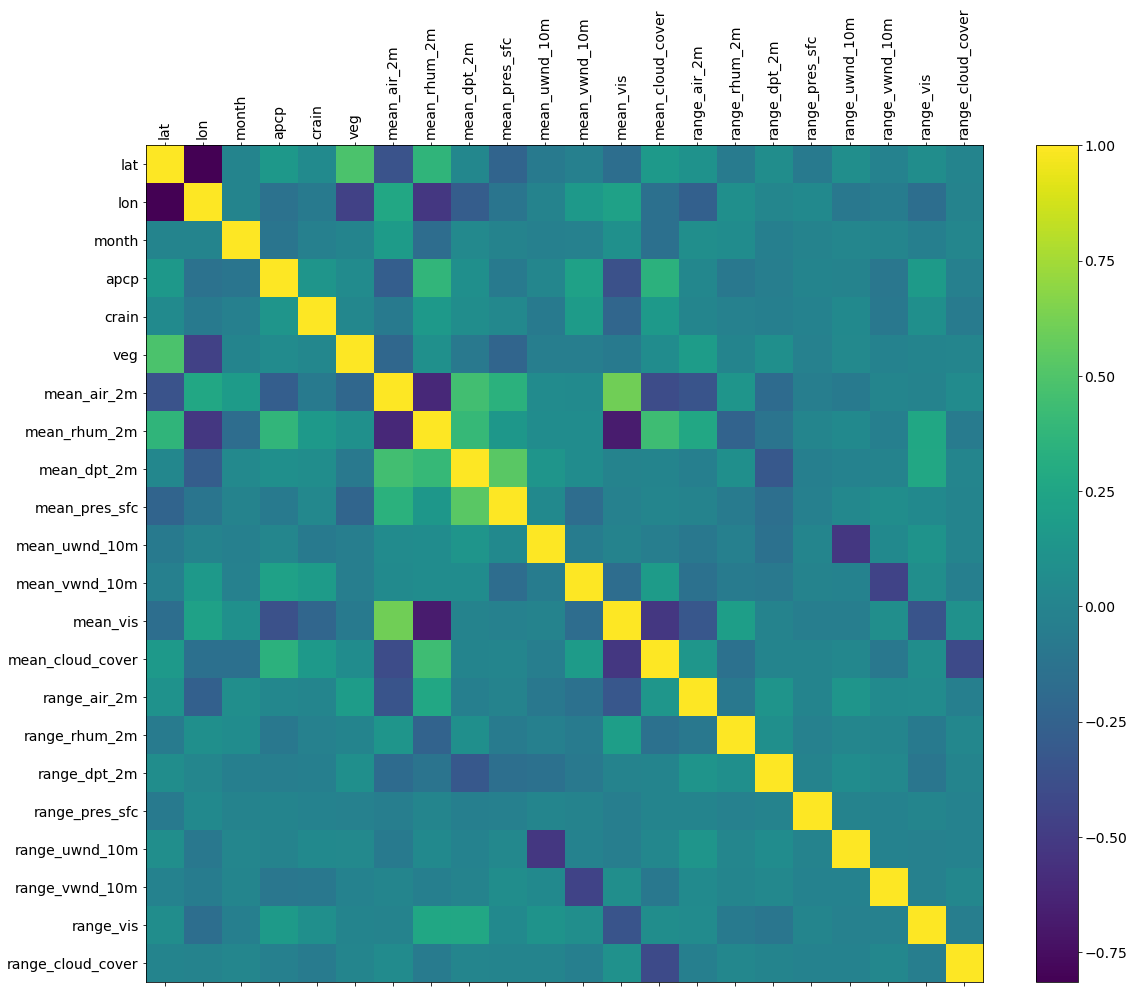

In [35]:
features = scaled_data[feature_names]

f = plt.figure(figsize=(19, 15))
plt.matshow(features.corr(), fignum=f.number)
plt.xticks(range(features.shape[1]), features.columns, fontsize=14, rotation=90)
plt.yticks(range(features.shape[1]), features.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

Much better! We still have some cases with strong correlations or anti-correlations - but we have removed the worst offenders.

## 11) Onehot encoded month

In [36]:
# One hot encode month

months = [
    'January',
    'February',
    'March',
    'April',
    'May',
    'June',
    'July',
    'August',
    'Septermber',
    'October',
    'November',
    'December'
]

# onehot encode month
onehot_encoder = OneHotEncoder(sparse=False)

# extract month from date column and convert to int
month = np.array(pd.DatetimeIndex(dates).month).reshape(-1, 1)
month = month.astype('int32')

# onehot encode
onehot_month = onehot_encoder.fit_transform(month).astype('int32')

# convert one hot encoded months to dataframe
onehot_month_df = pd.DataFrame(onehot_month, columns = months)

# reset indexes, set dtypes and concatenate one hot encoded months 
# back to orignal dataframe
onehot_month_df.reset_index(drop = True, inplace = True)
onehot_month_df = onehot_month_df.astype('int32')
scaled_data.reset_index(drop = True, inplace = True)
scaled_data = pd.concat([scaled_data, onehot_month_df], axis = 1)
scaled_data.drop('month', inplace=True, axis=1)

scaled_data['raw_lat'] = raw_lat
scaled_data['raw_lon'] = raw_lon
scaled_data['date'] = dates

scaled_data.to_parquet('/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_range_onehot_month_selective_box_cox.parquet')

## 11) PCA

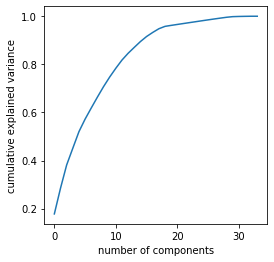

In [37]:
features_for_pca = [
    'lat',       
    'lon',       
#     'month',         
    'apcp',    
    'crain',     
    'veg',     
#     'ignition',       
    'mean_air_2m',      
    'mean_rhum_2m',    
    'mean_dpt_2m',     
    'mean_pres_sfc',     
    'mean_uwnd_10m',  
    'mean_vwnd_10m',   
    'mean_vis',      
    'mean_cloud_cover',    
    'total_fires',      
    'range_air_2m',       
    'range_rhum_2m',      
    'range_dpt_2m',      
    'range_pres_sfc',      
    'range_uwnd_10m', 
    'range_vwnd_10m', 
    'range_vis', 
    'range_cloud_cover',
    'January',
    'February',
    'March',
    'April',
    'May',
    'June',
    'July',
    'August',
    'Septermber',
    'October',
    'November',
    'December'
]

# Split labels and features.
train_labels = scaled_data['ignition']
train_features = scaled_data.drop('ignition', inplace=False, axis=1)

pca = PCA().fit(np.array(train_features[features_for_pca]))
fig = plt.figure(figsize = (4,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [38]:
n_components_list = [5, 10, 15, 20, 25, 30]

for n_components in n_components_list:
    col_names = [f'component_{i}' for i in range(1,(n_components + 1))]

    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(np.array(train_features[features_for_pca]))
    principal_df = pd.DataFrame(data = principal_components, columns = col_names)

    pca_result = pd.concat([principal_df, train_labels], axis = 1)

    for col in col_names:
        pca_result[col] = pca_result[col].astype('float32')

    pca_training_data_file = f'/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_range_onehot_month_selective_box_cox_pca{n_components}.parquet'
    
    pca_result['raw_lat'] = raw_lat
    pca_result['raw_lon'] = raw_lon
    pca_result['date'] = dates
    
    pca_result.to_parquet(pca_training_data_file)

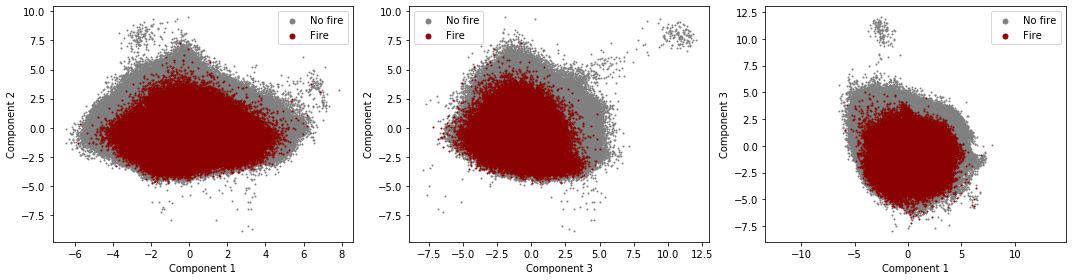

In [39]:
fire = pca_result[pca_result['ignition'] == 1]
no_fire = pca_result[pca_result['ignition'] == 0]

plt.subplots(1, 3, figsize=(15, 4))

plt.subplot(1, 3, 1)

plt.scatter(
    no_fire['component_1'], 
    no_fire['component_2'],
    color = 'gray',
    s = 1,
    label = 'No fire'
)

plt.scatter(
    fire['component_1'], 
    fire['component_2'],
    color = 'darkred',
    s = 1,
    label = 'Fire'
)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(markerscale=5)


plt.subplot(1, 3, 2)

plt.scatter(
    no_fire['component_3'], 
    no_fire['component_2'],
    color = 'gray',
    s = 1,
    label = 'No fire'
)

plt.scatter(
    fire['component_3'], 
    fire['component_2'],
    color = 'darkred',
    s = 1,
    label = 'Fire'
)

plt.xlabel('Component 3')
plt.ylabel('Component 2')
plt.legend(markerscale=5)


plt.subplot(1, 3, 3)

plt.scatter(
    no_fire['component_1'], 
    no_fire['component_3'],
    color = 'gray',
    s = 1,
    label = 'No fire'
)

plt.scatter(
    fire['component_1'], 
    fire['component_3'],
    color = 'darkred',
    s = 1,
    label = 'Fire'
)

plt.xlabel('Component 1')
plt.ylabel('Component 3')
plt.legend(markerscale=5)

plt.axis('equal')
plt.tight_layout()
plt.show()